# LSTMs and CNNs for Regression, Classification, Sequence to Sequence

In this tutorial, we will be learning directly from SMILES representation of molecules without using any intermediate molecule-to-static-length-tensor scheme.

We will explore:
* Recurrent Neural Networks
    - Vanilla RNN (Used in Task 1 - solubility)
    - BiDirectional Gated Recurrence Unit (Used in Task 3 - Protein Structure)
    - Long Short Term Memory (Left as exercise - easily pluggable in Tasks 1 and 3)
* Convolutional Neural Network
    - 1-D padded convolutions

We will train these networks for performing:
* Regression
* Classification

And we will use then in the following settings:
* Sequence-to-Scalar: Single scalar output per molecule or DNA/RNA sequence
* Sequence-to-Sequence: Scalar output for each token in the molecule or DNA/RNA string

The tasks we are training on are:
* Free Energy of Solvation Prediction - Regression task (continued from previous labs)
* Toxicity Prediction - Classification task (continued from previous labs) - left as exercise
* Protein Structure Prediction - Seq-to-Seq regression task (new dataset)

## Importing required Libraries

In [ ]:
import random
import os
import math
import pickle
import time
import re

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tqdm.auto as tqdm

import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data
from torch.nn.utils.rnn import (
    pad_sequence, 
    pack_padded_sequence,
    pad_packed_sequence,
)

from sklearn.metrics import (
    accuracy_score, 
    classification_report
)

In [ ]:
plt.style.use("ggplot")

## Random Seed for reproducibility

In [ ]:
seed = 42
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

# Regression Using RNNs

First we try out performing direct regression on the input SMILE strings 

## Getting and Preparing the Dataset

In [ ]:
!wget "https://raw.githubusercontent.com/devalab/ml4science_tut/master/regression_task/Tutorial/esol.csv"

--2022-05-06 12:07:48--  https://raw.githubusercontent.com/devalab/ml4science_tut/master/regression_task/Tutorial/esol.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96699 (94K) [text/plain]
Saving to: ‘esol.csv’

esol.csv            100%[===================>]  94.43K  --.-KB/s    in 0.005s  

2022-05-06 12:07:48 (17.2 MB/s) - ‘esol.csv’ saved [96699/96699]



In [ ]:
df = pd.read_csv('esol.csv')
df = df[['measured log solubility in mols per litre','smiles']]
df.head()

,measured log solubility in mols per litre,smiles
0,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,-2.06,CC(C)=CCCC(C)=CC(=O)
3,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,-1.33,c1ccsc1


In [ ]:
train_df, validate_df, test_df = np.split(df.sample(frac=1), [int(.8*len(df)), int(.9*len(df))])

## SMILES to Tensor transformation

### Generate the SMILES token vocabulary

In [ ]:
elements = {'Br', 'C', 'Cl', 'F', 'I', 'N', 'O', 'P', 'S','H','Si'}
vocab = set()
for indx,val in enumerate(list(df['smiles'].values)):
    temp_smile = re.sub(' ','',val)   ##remove spaces from the smile string
    for element in elements:
        search_obj = re.search(element,temp_smile)
        if search_obj:
            temp_smile = re.sub(element,'',temp_smile)
            vocab.add(element)
        search_obj = re.search(element.lower(),temp_smile)
        if search_obj:
            temp_smile = re.sub(element.lower(),'',temp_smile)
            vocab.add(element.lower())
    
    for i in temp_smile:
        vocab.add(i)
## convert vocab from set to list for indexing
vocab = list(vocab)

In [ ]:
vocab

['I',
 'Br',
 'F',
 'n',
 '5',
 '(',
 '2',
 '=',
 '#',
 'C',
 '[',
 'H',
 '3',
 '1',
 '6',
 'Cl',
 's',
 'N',
 '4',
 'P',
 '/',
 '7',
 ')',
 'S',
 '\\',
 'O',
 ']',
 'c',
 '8',
 'o']

### Use Vocabulary to convert SMILES to Tensors

In [ ]:
def smiles2vec(smile):
    indx = 0
    vec = []
    smile = smile.strip()
    while indx < len(smile):
        if (indx is not len(smile) - 1) and (smile[indx] + smile[indx+1]) in vocab:
            vec.append(vocab.index(smile[indx] + smile[indx+1]))
            indx += 2
            
        elif (smile[indx]) in vocab:
            vec.append(vocab.index(smile[indx]))
            indx += 1
    return vec

In [ ]:
print(df['smiles'][0])
print(smiles2vec(df['smiles'][0]))

OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O 
[25, 9, 9, 12, 25, 9, 5, 25, 9, 9, 6, 25, 9, 5, 25, 9, 5, 9, 8, 17, 22, 27, 13, 27, 27, 27, 27, 27, 13, 22, 9, 5, 25, 22, 9, 5, 25, 22, 9, 6, 25, 22, 9, 5, 25, 22, 9, 5, 25, 22, 9, 12, 25]


In [ ]:
def vec2onehot(vec): 
    tensor = torch.zeros(len(vec), len(vocab))
    for i, v in enumerate(vec):
        tensor[i][v] = 1
    return tensor

vec2onehot(smiles2vec(df['smiles'][0]))

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

## Setting up the Neural Networks

### Deciding on Hyperparameters

In [ ]:
INPUT_SIZE = 1      # rnn input size
HIDDEN_SIZE = 120   # rnn hidden size
LR = 1e-2           # learning rate
BATCH_SIZE = 32

### Defining the Network Architecture

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.rnn = nn.RNN(
            input_size=INPUT_SIZE,
            hidden_size=HIDDEN_SIZE,     # rnn hidden unit
            num_layers=1,                # number of rnn layer
            batch_first=True,
        )
        self.out = nn.Linear(HIDDEN_SIZE, 60)
        self.final = nn.Linear(60, 1)

    def forward(self, x):
        h_state = torch.zeros(1,1,HIDDEN_SIZE).float()
        r_out, h_state = self.rnn(x.float(), h_state)
        r_out = torch.mean(r_out,dim=1)
        r_out = self.out(r_out)
        r_out = F.relu(r_out)
        prediction = self.final(r_out)
        return prediction

### Make the Network, Optimizer, LR-Scheduler

In [ ]:
model = Model()
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',verbose=True,patience=5)

### The Training Loop

In [ ]:
def train(model, epoch, train_set):
    model.train()
    sample_index = 0
    epoch_train_loss=[]
    random_indexes=np.random.permutation(len(train_set))
    MAXITER = len(train_set)/BATCH_SIZE
    for batch_no in range(0,round(MAXITER)):
        optimizer.zero_grad()
        train_loss = torch.zeros(1, 1)
        
        for iter_no in range(0, BATCH_SIZE):
            sample_index = sample_index%len(train_set)
            index=random_indexes[sample_index]
            data = train_set[index]
    
            smile = data[1]
            smile_vec = smiles2vec(smile)
            smile_vec = torch.FloatTensor(smile_vec)
            smile_vec = smile_vec.unsqueeze(0)
            smile_vec = smile_vec.unsqueeze(2)
            y_hat = model(smile_vec)
            
            y = torch.FloatTensor([data[0]])
            error = ((y_hat - y)**2 / BATCH_SIZE)
            train_loss = train_loss + error
            
            sample_index += 1

        epoch_train_loss.append(train_loss.item())
        train_loss.backward()
        optimizer.step()
    
    return np.mean(epoch_train_loss)

In [ ]:
def validation(model):
    model.eval()
    val_loss = torch.zeros(1, 1)
    for index,data in enumerate(validate_df.values):
        smile = data[1]
        smile_vec = smiles2vec(smile)
        smile_vec = torch.FloatTensor(smile_vec)
        smile_vec = smile_vec.unsqueeze(0)
        smile_vec = smile_vec.unsqueeze(2)
        y_hat = model(smile_vec)

        y = torch.FloatTensor([data[0]])
        error = (y_hat - y)**2
        val_loss = val_loss + error

    return val_loss.item()/len(validate_df)

In [ ]:
def test(model):
    model.eval()
    test_loss = torch.zeros(1, 1)
    for index,data in enumerate(test_df.values):
        smile = data[1]
        smile_vec = smiles2vec(smile)
        smile_vec = torch.FloatTensor(smile_vec)
        smile_vec = smile_vec.unsqueeze(0)
        smile_vec = smile_vec.unsqueeze(2)
        y_hat = model(smile_vec)

        y = torch.FloatTensor([data[0]])
        error = (y_hat - y)**2
        test_loss = test_loss + error

    return test_loss.item()/len(test_df)

In [ ]:
train_loss_arr = []
validation_loss_arr = []
for epoch in tqdm.trange(100):
    train_loss = train(model, epoch, train_df.values)
    val_loss = validation(model)
    train_loss_arr.append(train_loss)
    validation_loss_arr.append(val_loss)
    print("epoch_no: ",epoch ,"training loss: ",train_loss,"validation loss: ",val_loss)
    scheduler.step(val_loss)

  0%|          | 0/100 [00:00<?, ?it/s]

epoch_no:  0 training loss:  5.191342098372323 validation loss:  3.619786625414823
epoch_no:  1 training loss:  4.145444682666233 validation loss:  2.876372210747373
epoch_no:  2 training loss:  3.4775442566190446 validation loss:  3.1462291616254148
epoch_no:  3 training loss:  3.330500747476305 validation loss:  2.8532720245091263
epoch_no:  4 training loss:  3.451981403997966 validation loss:  4.0878922454023785
epoch_no:  5 training loss:  3.6334910690784454 validation loss:  2.969700095927821
epoch_no:  6 training loss:  3.281593314238957 validation loss:  3.0043950713841263
epoch_no:  7 training loss:  3.0976370019572124 validation loss:  2.7904284992049226
epoch_no:  8 training loss:  2.920355894735881 validation loss:  3.0194121504251936
epoch_no:  9 training loss:  2.8185903302260806 validation loss:  2.850295075273092
epoch_no:  10 training loss:  2.6420501342841556 validation loss:  1.9923484599695795
epoch_no:  11 training loss:  2.4449285524232045 validation loss:  2.29377

## Analyzing how well the model trained

### Performance on the Test Set

In [ ]:
print("Test loss: ",test(model))

Test loss:  1.7059747476493363


### Training and Validation Curves 

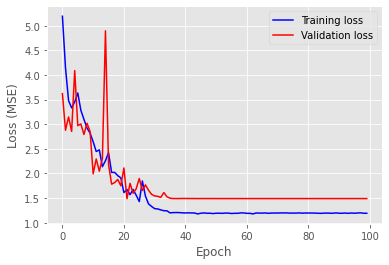

In [ ]:
plt.plot(train_loss_arr,'b',label='Training loss')
plt.plot(validation_loss_arr,'r',label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.plot()
plt.show()

# Regression using CNNs

## Setting up the Neural Networks

### Convolutional Network architecture

In [ ]:
class ConvModel(nn.Module):
    def __init__(self):
        super(ConvModel, self).__init__()
        self.cnn_1 = nn.Conv1d(
            in_channels=INPUT_SIZE, 
            out_channels=HIDDEN_SIZE,
            kernel_size=3,
            padding=1,
            stride=1,
            bias=True, 
            padding_mode='zeros', 
        )
        self.cnn_2 = nn.Conv1d(
            in_channels=HIDDEN_SIZE, 
            out_channels=HIDDEN_SIZE,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True, 
            padding_mode='zeros', 
        )
        self.out = nn.Linear(HIDDEN_SIZE, 60)
        self.final = nn.Linear(60, 1)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.cnn_1(x.float())
        x = F.relu(x)
        x = self.cnn_2(x.float())
        x = torch.mean(x,dim=2)
        x = F.relu(x)
        x = self.out(x)
        x = F.relu(x)
        prediction = self.final(x)
        return prediction

### Running Model on Sample Data

Just as a sanity check to debug shapes and sizes of tensors

In [ ]:
smile = train_df.values[3][1]
smile_vec = torch.FloatTensor(smiles2vec(smile))
smile_vec = smile_vec.unsqueeze(0).unsqueeze(2)

In [ ]:
model = ConvModel()
model(smile_vec)

tensor([[-0.4208]], grad_fn=<AddmmBackward0>)

In [ ]:
model = Model()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',verbose=True,patience=5)

## Running the training loop

### The actual Train Loop

This calls functions in the previously defined segment.

In [ ]:
train_loss_arr = []
validation_loss_arr = []
for epoch in tqdm.trange(100):
    train_loss = train(model, epoch, train_df.values)
    val_loss = validation(model)
    train_loss_arr.append(train_loss)
    validation_loss_arr.append(val_loss)
    print("epoch_no: ",epoch ,"training loss: ",train_loss,"validation loss: ",val_loss)
    scheduler.step(val_loss)

  0%|          | 0/100 [00:00<?, ?it/s]

epoch_no:  0 training loss:  6.304792348827634 validation loss:  3.7689608683628317
epoch_no:  1 training loss:  4.241602403776986 validation loss:  3.4590067905662334
epoch_no:  2 training loss:  4.199346934046064 validation loss:  3.401875993846792
epoch_no:  3 training loss:  4.043174309389932 validation loss:  3.1916090703643527
epoch_no:  4 training loss:  3.517755150794983 validation loss:  2.838755109668833
epoch_no:  5 training loss:  3.2935304599148885 validation loss:  2.868028218767284
epoch_no:  6 training loss:  3.1327324552195415 validation loss:  2.772617576396571
epoch_no:  7 training loss:  2.891634796346937 validation loss:  2.441706024439989
epoch_no:  8 training loss:  2.6647577626364574 validation loss:  2.3857508296460175
epoch_no:  9 training loss:  2.7338554433413913 validation loss:  2.51256703064505
epoch_no:  10 training loss:  2.556085929274559 validation loss:  2.3011444901998064
epoch_no:  11 training loss:  2.499983174460275 validation loss:  2.0550149563

## Analyzing how well the model trained

### Performance on the Test Set

In [ ]:
print("Test loss: ",test(model))

Test loss:  1.7552707638360758


### Training and Validation Curves 

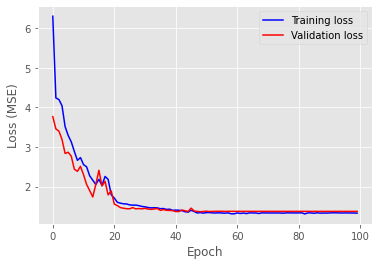

In [ ]:
plt.plot(train_loss_arr,'b',label='Training loss')
plt.plot(validation_loss_arr,'r',label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.plot()
plt.show()

# Seq-to-Seq Regression with Bi-GRUs

## Preparing the DataSet

### Dataset Download and Extraction

In [ ]:
!wget "https://github.com/devalab/ml4science_tut/blob/master/classification_task/Datasets.zip?raw=true" -O "pstruct.zip"

--2022-05-06 12:46:32--  https://github.com/devalab/ml4science_tut/blob/master/classification_task/Datasets.zip?raw=true
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/devalab/ml4science_tut/raw/master/classification_task/Datasets.zip [following]
--2022-05-06 12:46:32--  https://github.com/devalab/ml4science_tut/raw/master/classification_task/Datasets.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/devalab/ml4science_tut/master/classification_task/Datasets.zip [following]
--2022-05-06 12:46:32--  https://raw.githubusercontent.com/devalab/ml4science_tut/master/classification_task/Datasets.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubuserco

In [ ]:
!unzip "pstruct.zip"

Archive:  pstruct.zip
   creating: Datasets/
  inflating: Datasets/test.pkl       
  inflating: Datasets/train.pkl      
  inflating: Datasets/val.pkl        


In [ ]:
!mv "Datasets" "pstruct"
!rm "pstruct.zip"

### Labels to Index Maps

In [ ]:
target_names=['H','E','C']
residue_names = ['A', 'C', 'E', 'D', 'G', 'F', 'I', 'H', 'K', 'M', 'L', 'N', 
                 'Q', 'P', 'S', 'R', 'T', 'W', 'V', 'Y', 'X','NoSeq']

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_workers = 1
if device.type == 'cuda':
  num_workers = 2

device, num_workers

(device(type='cuda'), 2)

### Torch Dataset Class

In [ ]:
class Dataset(data.Dataset):

    @staticmethod
    def load_from_pkl(path):
        with open(path, 'rb') as f:
            var = pickle.load(f)
        return var

    def __init__(self, path_to_pkl):
        self.data = self.load_from_pkl(path_to_pkl)
        self.ids = list(self.data.keys())

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        id = self.ids[index]
        dict = self.data[id]
        seq = dict["sequence"]
        pssm = dict["pssm"]
        length = len(seq)
        
        secstr = dict["secstr"]
        secstr_q3 = dict["secstr_q3"]

        return id,seq,pssm,length,secstr,secstr_q3

### Pad Batch for Collating

In [ ]:
def pad_batch(DataLoaderBatch):
    """
    DataLoaderBatch should be a list of (sequence, target, length) tuples...
    Returns a padded tensor of sequences sorted from longest to shortest, 
    """
    batch_size = len(DataLoaderBatch)
    batch_split = list(zip(*DataLoaderBatch))

    ids, seqs, pssms, lengths, secstrs, secstrs_q3 = batch_split  # 0 to 5 idx
    max_length = max(lengths)

    padded_seqs = np.ones((max_length, batch_size))*30
    padded_pssms = np.zeros((max_length,batch_size,22))
    padded_secstrs = np.ones((max_length,batch_size))*30
    padded_secstrs_q3 = np.ones((max_length,batch_size))*30
    
    for i, l in enumerate(lengths):
        padded_seqs[:l,i] = seqs[i][:l]
        padded_pssms[:l,i,:] = pssms[i][:l][:]
        padded_secstrs[:l,i] = secstrs[i][:l]
        padded_secstrs_q3[:l,i] = secstrs_q3[i][:l]
    return (
        torch.tensor(padded_seqs).type(torch.LongTensor), 
        torch.tensor(padded_pssms).type(torch.float), 
        torch.tensor(lengths), torch.tensor(padded_secstrs).type(torch.LongTensor), 
        torch.tensor(padded_secstrs_q3).type(torch.LongTensor),
    )

### Dataloaders on the ready

In [ ]:
# Batch Size for data parallelism
batch_size = 64

# Load train, test and validation data
train = Dataset("./pstruct/train.pkl")
val = Dataset("./pstruct/val.pkl")
test = Dataset("./pstruct/test.pkl")

# Data Generators for each set.
train_gen = data.DataLoader(
    train, 
    batch_size=batch_size, 
    shuffle=True, 
    collate_fn=pad_batch,
    num_workers=num_workers
)
val_gen = data.DataLoader(
    val, 
    batch_size=batch_size,
    shuffle=False,
    collate_fn=pad_batch,
    num_workers=num_workers
)
test_gen = data.DataLoader(
    test, 
    batch_size=batch_size,
    shuffle=False,
    collate_fn=pad_batch,
    num_workers=num_workers
)

## Making the Models

### Preconfigured Dense Layers

In [ ]:
class Dense(nn.Module):
    def __init__(
        self,
        input_dim,
        output_dim,
        dropout = 0.2,
        normalization = True,
        activation = F.relu
    ):
        super(Dense, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.dropout_rate = dropout
        self.activation = activation
        self.n_state = normalization        
        self.linear = nn.Linear(self.input_dim,self.output_dim)
        self.layernorm = nn.LayerNorm(self.output_dim)
        self.dropout = nn.Dropout(p=self.dropout_rate)
        
    def forward(self, x):
        x = self.linear(x)
        x = self.activation(x)
        if self.n_state:
            x = self.layernorm(x)
        x = self.dropout(x)
        return x

### Pre-configured GRU Layers

In [ ]:
class GRUBidirectional(nn.Module):
    def __init__(self,inp,out,dropout=0.1,activation=F.relu):
        super(GRUBidirectional,self).__init__()
        self.gru = nn.GRU(inp,out,bidirectional=True)
        self.dropout_rate = dropout
        self.layernorm = nn.LayerNorm(2*out)
        self.activation = activation
        self.input_dim = inp
        self.output_dim = out
        self.dropout = nn.Dropout(p=self.dropout_rate)

    def forward(self,x,lengths):
        x_ = pack_padded_sequence(x,lengths,enforce_sorted=False)
        out,_ = self.gru(x_)
        out,_ = pad_packed_sequence(out)
        out = self.activation(out)
        out = self.layernorm(out)
        if self.input_dim == 2*self.output_dim:
            out = out+x
        out = self.dropout(out)
        return out

### Full Model Setup

In [ ]:
class Net(nn.Module):
    def __init__(self,embedding_count=31,embedding_dim=50):
        super(Net, self).__init__()
        self.embedding = nn.Embedding(
            embedding_count,
            embedding_dim=embedding_dim,
            padding_idx=30,
        )
        self.layernorm = nn.LayerNorm(22+embedding_dim)
        # GRU layer
        self.gru_1 = GRUBidirectional(22+embedding_dim,64,0.2)
        # Output layers
        self.linear_1 = Dense(128,64)
        self.Q3 = Dense(64,3,dropout=0)
        
    def forward(self,x,pssm,x_lengths):
        emb = self.embedding(x)
        emb = torch.cat([emb,pssm],dim=-1)
        x_normalized = self.layernorm(emb)
        gru = self.gru_1(x_normalized,x_lengths)
        out = self.linear_1(gru)
        Q3 = self.Q3(out)
        return Q3

## Training

### Defining Model, Loss function and Optimizer

In [ ]:
network = Net().to(device)
criterion = nn.CrossEntropyLoss(ignore_index=30)
optimizer = torch.optim.Adam(network.parameters(),lr=0.001)

### Training Function

In [ ]:
def train_epoch(generator):
    #     Set the network in to train mode
    #     Enables dropout.
    network.train()
    total_loss = 0.
    start_time = time.time() # Track training time.
    prediction = []
    g_t = []
    for seq,pssm,length,q8,q3 in tqdm.tqdm(generator, desc="Training"):
        optimizer.zero_grad()  # Make all gradients at each trainable parameter zero.
        output = network(
            seq.to(device),
            pssm.to(device),
            length.cpu(),
        ) # Perform a forward pass
        
        loss = criterion(output.view(-1,3).to(device),q3.view(-1).to(device))  #Compute the loss function 
        loss.backward() # Perform back propagation 
        torch.nn.utils.clip_grad_norm_(network.parameters(), 0.5)  # Clip gradients to increase stability of training
        optimizer.step()  # Perform the optimization step.
        
        total_loss += loss.cpu().detach().numpy()/batch_size   # Track loss for analysis
        
        # store all predictions to calculate accuracy at end of epoch
        for i in range(len(length)):
            prediction.append(output[0:length[i],i,:].cpu().detach().numpy())
            g_t.append(q3[0:length[i],i].cpu().detach().numpy())

    predictions = np.argmax(np.concatenate(prediction,axis=0),axis=-1)
    g_ts = np.concatenate(g_t)
    
    # calculate accuracy
    acc = accuracy_score(predictions,g_ts) 
    end_time = time.time()
    return end_time-start_time , total_loss, acc

### Evaluating Function

In [ ]:
def evaluate(generator, print_acc_report=False,output_sample=False):
    
    with torch.no_grad(): # disable gradients as no optimization done during evaluation
        network.eval()  # set network to evaluation mode to disable dropouts
        total_loss = 0.
        start_time = time.time() # Track evaluation time
        prediction = []
        g_t = []   
        for seq,pssm,length,q8,q3 in tqdm.tqdm(generator, desc='Validation'):
            
            #    Get predictions
            output = network(seq.to(device),pssm.to(device),length.cpu())
            
            #    Calculate loss for analysis
            loss = criterion(output.view(-1,3).to(device),q3.view(-1).to(device))        
            total_loss += loss.cpu().detach().numpy()/batch_size
            for i in range(len(length)):
                prediction.append(output[0:length[i],i,:].cpu().detach().numpy())
                g_t.append(q3[0:length[i],i].cpu().detach().numpy())
                
        #   calculate  accuracy for analysis       
        predictions = np.argmax(np.concatenate(prediction,axis=0),axis=-1)
        g_ts = np.concatenate(g_t)
        acc = accuracy_score(predictions,g_ts) 
        end_time = time.time()
        if print_acc_report:
            print (classification_report(g_ts,predictions,target_names=target_names))
    return end_time-start_time, total_loss, acc

### Training Loop

In [ ]:
train_acc_history = []
val_acc_history = []
train_loss_history = []
val_loss_history = []
for i in range(40):
    # Train epoch
    run_time,train_loss,train_acc = train_epoch(train_gen)
    
    # Validation step
    _,val_loss,val_acc = evaluate(val_gen)
    
    # Track performance of network during training
    train_acc_history.append(train_acc)
    val_acc_history.append(val_acc)
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    
    # Print performance metrics
    print (f"Epoch:{i}, train_loss:{train_loss}, train_acc:{train_acc}, val_acc:{val_acc}")

Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch:0, train_loss:1.294127531349659, train_acc:0.5465359183895214, val_acc:0.6131754015901347


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:02<?, ?it/s]

Epoch:1, train_loss:1.108926243148744, train_acc:0.657292245357186, val_acc:0.7056425442154795


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch:2, train_loss:1.0387704353779554, train_acc:0.6984804061596914, val_acc:0.7280748012331657


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch:3, train_loss:0.9996220916509628, train_acc:0.7158231586031163, val_acc:0.7376277786792147


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa7ac9d9f80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa7ac9d9f80>
Traceback (most recent call last):
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
AssertionError: can only test a child process
    if w.is_alive():
  File "/usr/lib/pytho

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch:4, train_loss:0.9677260229364038, train_acc:0.7325402680976424, val_acc:0.754097030666883


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch:5, train_loss:0.9312822064384818, train_acc:0.7475443076130407, val_acc:0.7666720752880091


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch:6, train_loss:0.9135822504758835, train_acc:0.7551580493259004, val_acc:0.7697347071231543


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch:7, train_loss:0.8906093221157789, train_acc:0.762352066987608, val_acc:0.769917248093461


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch:8, train_loss:0.8735363064333797, train_acc:0.7661427272074067, val_acc:0.7616623397695927


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch:9, train_loss:0.8654687711969018, train_acc:0.7680941373575435, val_acc:0.7804843420412136


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch:10, train_loss:0.8503644121810794, train_acc:0.7697046860131123, val_acc:0.7810522472821678


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch:11, train_loss:0.8371281567960978, train_acc:0.7719321151112926, val_acc:0.7866704527016064


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch:12, train_loss:0.8244730588048697, train_acc:0.7788282075592389, val_acc:0.7898953431770241


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch:13, train_loss:0.8158685537055135, train_acc:0.7800172796623982, val_acc:0.7940937854940776


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch:14, train_loss:0.800300513394177, train_acc:0.784218025176433, val_acc:0.7913759532695116


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch:15, train_loss:0.795745481736958, train_acc:0.784677180505877, val_acc:0.7941343501541457


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch:16, train_loss:0.785329039208591, train_acc:0.788264550579815, val_acc:0.7954527016063605


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch:17, train_loss:0.776418037712574, train_acc:0.7901064294013631, val_acc:0.7900373194872627


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch:18, train_loss:0.7777391569688916, train_acc:0.7890417848874807, val_acc:0.801314294986208


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa7ac9d9f80>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa7ac9d9f80>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    if w.is_alive():
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in

Epoch:19, train_loss:0.7616170551627874, train_acc:0.7938304945733798, val_acc:0.7971158526691546


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch:20, train_loss:0.7629430005326867, train_acc:0.793373967995822, val_acc:0.8025109524582184


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch:21, train_loss:0.7544755898416042, train_acc:0.7945761838584119, val_acc:0.8045594677916599


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch:22, train_loss:0.7533543696627021, train_acc:0.794856584059599, val_acc:0.8044783384715236


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch:23, train_loss:0.7436113827861845, train_acc:0.7980242300823851, val_acc:0.8032411163394451


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa7ac9d9f80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa7ac9d9f80>
Traceback (most recent call last):
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
AssertionError: can only test a child process
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch:24, train_loss:0.7345006251707673, train_acc:0.8005452031411833, val_acc:0.810603602141814


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch:25, train_loss:0.7259507430717349, train_acc:0.8027875285000518, val_acc:0.8087579101087133


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch:26, train_loss:0.7285664053633809, train_acc:0.8012041436139731, val_acc:0.8082711341878955


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch:27, train_loss:0.7164920838549733, train_acc:0.8048011524448269, val_acc:0.8112729190329385


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch:28, train_loss:0.7155566718429327, train_acc:0.8051385089368802, val_acc:0.8095083563199741


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa7ac9d9f80>
    if w.is_alive():
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa7ac9d9f80>
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    self._shutdown_workers()
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
AssertionError: can only test a child process
    if w.is_alive():
  File "/usr/lib/pytho

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch:29, train_loss:0.7103649470955133, train_acc:0.806144444658639, val_acc:0.8121247768943696


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch:30, train_loss:0.7087500356137753, train_acc:0.8060804783627432, val_acc:0.8097923089404511


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch:31, train_loss:0.7051063510589302, train_acc:0.8073711955388329, val_acc:0.8108064254421548


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch:32, train_loss:0.7033529081381857, train_acc:0.8073054767416795, val_acc:0.8164651955216615


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch:33, train_loss:0.699805666692555, train_acc:0.808632996444175, val_acc:0.817418465033263


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch:34, train_loss:0.6968475114554167, train_acc:0.8099456198859822, val_acc:0.8167085834820704


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch:35, train_loss:0.6976621951907873, train_acc:0.8082456936662852, val_acc:0.816586889501866


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa7ac9d9f80>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa7ac9d9f80>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    self._shutdown_workers()
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch:36, train_loss:0.6947246473282576, train_acc:0.8093103381801676, val_acc:0.8166680188220022


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch:37, train_loss:0.6914609726518393, train_acc:0.8098448510636806, val_acc:0.8179863702742171


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa7ac9d9f80>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa7ac9d9f80>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch:38, train_loss:0.6846982799470425, train_acc:0.812307991580984, val_acc:0.820947590459192


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch:39, train_loss:0.6777363149449229, train_acc:0.814225227956601, val_acc:0.819608956676943


## Seeing the Training Results

### Final Test Accuracy

In [ ]:
_,_,test_accuracy = evaluate(test_gen,True,True)
print ("Test Accuracy - ",test_accuracy)

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

NameError: ignored

### Accuracy Curves

In [ ]:
plt.plot(train_acc_history,label = "Train_accuracy")
plt.plot(val_acc_history,label = "Validation_accuracy")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy in %")
plt.title("Performance with time")
plt.show()

### Loss Curves

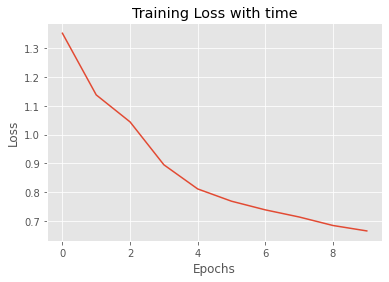

In [ ]:
plt.plot(train_loss_history)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss with time")
plt.show()

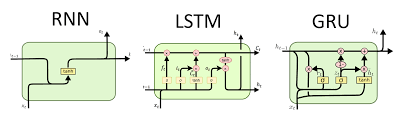

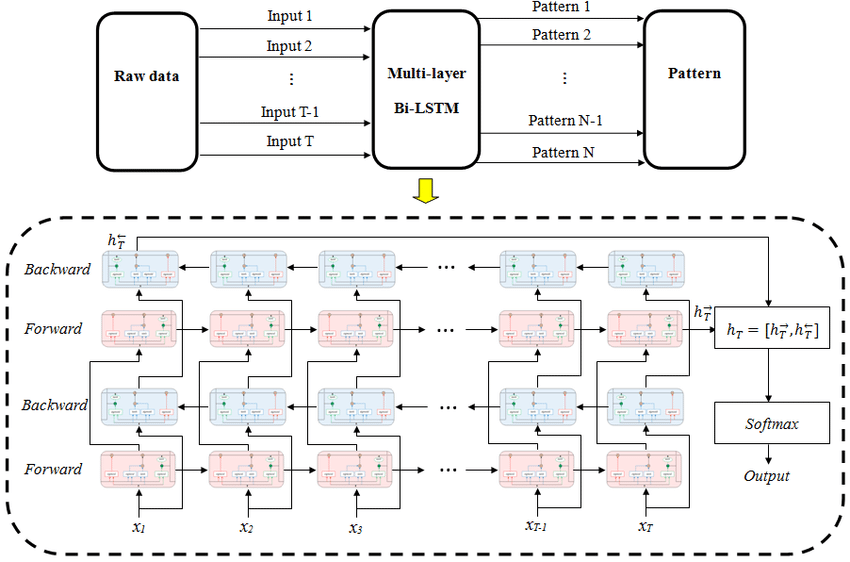